#  最大池化下采样四次 512-256-128-64-32

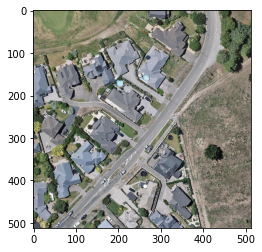

In [1]:
import matplotlib.pyplot as plt 
import torch 
from PIL import Image
import numpy as np 

image_path=r'G:\zyx\data\data_png\test\image\2_1.png'
with open(image_path, 'rb') as fp:
        image = Image.open(fp).convert('RGB')
image = torch.FloatTensor(np.asarray(image)) / 255
plt.imshow(image) # 显示图片
plt.show()

torch.Size([3, 512, 512])
torch.Size([256, 256, 3])
torch.Size([128, 128, 3])
torch.Size([64, 64, 3])
torch.Size([32, 32, 3])


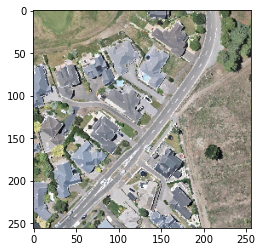

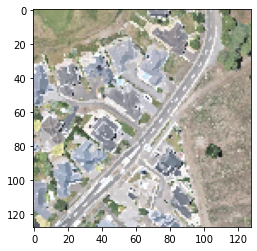

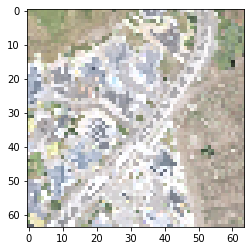

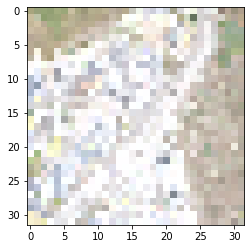

In [2]:
image = image.permute(2, 0, 1)
print(image.shape)
image1=torch.nn.MaxPool2d(2)(image)
image2=torch.nn.MaxPool2d(2)(image1)
image3=torch.nn.MaxPool2d(2)(image2)
image4=torch.nn.MaxPool2d(2)(image3)
image1 = image1.permute(1,2,0)
image2 = image2.permute(1,2,0)
image3 = image3.permute(1,2,0)
image4 = image4.permute(1,2,0)
print(image1.size())
print(image2.size())
print(image3.size())
print(image4.size())
plt.imshow(image1) # 显示图片
plt.show()
plt.imshow(image2) # 显示图片
plt.show()
plt.imshow(image3) # 显示图片
plt.show()
plt.imshow(image4) # 显示图片
plt.show()

# 先使用sidewindow，再使用最大池化

In [72]:
import torch.nn as nn
import torch.nn.functional as F


class SideWindowFilter(nn.Module):

    def __init__(self, radius, iteration, filter='box'):
        super(SideWindowFilter, self).__init__()
        self.radius = radius
        self.iteration = iteration
        self.kernel_size = 2 * self.radius + 1
        self.filter = filter

    def forward(self, im):
        b, c, h, w = im.size()

        d = torch.zeros(b, 8, h, w, dtype=torch.float)
        res = im.clone()

        if self.filter.lower() == 'box':
            filter = torch.ones(1, 1, self.kernel_size, self.kernel_size)
            L, R, U, D = [filter.clone() for _ in range(4)]

            L[:, :, :, self.radius + 1:] = 0
            R[:, :, :, 0: self.radius] = 0
            U[:, :, self.radius + 1:, :] = 0
            D[:, :, 0: self.radius, :] = 0

            NW, NE, SW, SE = U.clone(), U.clone(), D.clone(), D.clone()

            L, R, U, D = L / ((self.radius + 1) * self.kernel_size), R / ((self.radius + 1) * self.kernel_size), \
                         U / ((self.radius + 1) * self.kernel_size), D / ((self.radius + 1) * self.kernel_size)

            NW[:, :, :, self.radius + 1:] = 0
            NE[:, :, :, 0: self.radius] = 0
            SW[:, :, :, self.radius + 1:] = 0
            SE[:, :, :, 0: self.radius] = 0

            NW, NE, SW, SE = NW / ((self.radius + 1) ** 2), NE / ((self.radius + 1) ** 2), \
                             SW / ((self.radius + 1) ** 2), SE / ((self.radius + 1) ** 2)

            # sum = self.kernel_size * self.kernel_size
            # sum_L, sum_R, sum_U, sum_D, sum_NW, sum_NE, sum_SW, sum_SE = \
            #     (self.radius + 1) * self.kernel_size, (self.radius + 1) * self.kernel_size, \
            #     (self.radius + 1) * self.kernel_size, (self.radius + 1) * self.kernel_size, \
            #     (self.radius + 1) ** 2, (self.radius + 1) ** 2, (self.radius + 1) ** 2, (self.radius + 1) ** 2

            print('L:', L)
            print('R:', R)
            print('U:', U)
            print('D:', D)
            print('NW:', NW)
            print('NE:', NE)
            print('SW:', SW)
            print('SE:', SE)

        for ch in range(c):
            im_ch = im[:, ch, ::].clone().view(b, 1, h, w)
            # print('im size in each channel:', im_ch.size())

            for i in range(self.iteration):
                # print('###', (F.conv2d(input=im_ch, weight=L, padding=(self.radius, self.radius)) / sum_L -
                # im_ch).size(), d[:, 0,::].size())
                d[:, 0, ::] = F.conv2d(input=im_ch, weight=L, padding=(self.radius, self.radius)) - im_ch
                d[:, 1, ::] = F.conv2d(input=im_ch, weight=R, padding=(self.radius, self.radius)) - im_ch
                d[:, 2, ::] = F.conv2d(input=im_ch, weight=U, padding=(self.radius, self.radius)) - im_ch
                d[:, 3, ::] = F.conv2d(input=im_ch, weight=D, padding=(self.radius, self.radius)) - im_ch
                d[:, 4, ::] = F.conv2d(input=im_ch, weight=NW, padding=(self.radius, self.radius)) - im_ch
                d[:, 5, ::] = F.conv2d(input=im_ch, weight=NE, padding=(self.radius, self.radius)) - im_ch
                d[:, 6, ::] = F.conv2d(input=im_ch, weight=SW, padding=(self.radius, self.radius)) - im_ch
                d[:, 7, ::] = F.conv2d(input=im_ch, weight=SE, padding=(self.radius, self.radius)) - im_ch
      
                d_abs = torch.abs(d)
                # print('im_ch', im_ch)
                # print('dm = ', d_abs.shape, d_abs)
                mask_min = torch.argmin(d_abs, dim=1, keepdim=True)
                # print('mask min = ', mask_min.shape, mask_min)
                dm = torch.gather(input=d, dim=1, index=mask_min)
                im_ch = dm + im_ch

            res[:, ch, ::] = im_ch
        return res

img =  torch.Size([1, 3, 512, 512])
L: tensor([[[[0.1667, 0.1667, 0.0000],
          [0.1667, 0.1667, 0.0000],
          [0.1667, 0.1667, 0.0000]]]])
R: tensor([[[[0.0000, 0.1667, 0.1667],
          [0.0000, 0.1667, 0.1667],
          [0.0000, 0.1667, 0.1667]]]])
U: tensor([[[[0.1667, 0.1667, 0.1667],
          [0.1667, 0.1667, 0.1667],
          [0.0000, 0.0000, 0.0000]]]])
D: tensor([[[[0.0000, 0.0000, 0.0000],
          [0.1667, 0.1667, 0.1667],
          [0.1667, 0.1667, 0.1667]]]])
NW: tensor([[[[0.2500, 0.2500, 0.0000],
          [0.2500, 0.2500, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])
NE: tensor([[[[0.0000, 0.2500, 0.2500],
          [0.0000, 0.2500, 0.2500],
          [0.0000, 0.0000, 0.0000]]]])
SW: tensor([[[[0.0000, 0.0000, 0.0000],
          [0.2500, 0.2500, 0.0000],
          [0.2500, 0.2500, 0.0000]]]])
SE: tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.2500, 0.2500],
          [0.0000, 0.2500, 0.2500]]]])
(512, 512, 3)


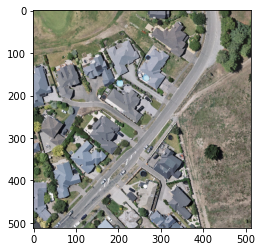

In [73]:
s = SideWindowFilter(radius=1, iteration=1)

image_path=r'G:\zyx\data\data_png\test\image\2_1.png'
with open(image_path, 'rb') as fp:
        image = Image.open(fp).convert('RGB')
img = torch.FloatTensor(np.asarray(image)) 

h, w, c = img.size()
img = img.permute(2,0,1).unsqueeze(dim=0)
print('img = ', img.shape)

res = s.forward(img)
if res.size(1) == 3:
    img_res = np.transpose(np.squeeze(res.data.numpy()), (1, 2, 0))
else:
    img_res = np.squeeze(res.data.numpy())
print(img_res.shape)
plt.imshow(img_res/255) # 显示图片

(3, 512, 512)


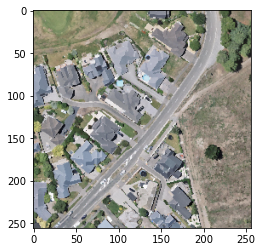

In [74]:
img=np.transpose(img_res,(2,0,1))
print(img.shape)
img = torch.FloatTensor(np.asarray(img)) 
image2=torch.nn.MaxPool2d(2)(img)
image2 = image2.permute(1,2,0)
plt.imshow(image2/255) # 显示图片

img =  torch.Size([1, 3, 256, 256])
L: tensor([[[[0.1667, 0.1667, 0.0000],
          [0.1667, 0.1667, 0.0000],
          [0.1667, 0.1667, 0.0000]]]])
R: tensor([[[[0.0000, 0.1667, 0.1667],
          [0.0000, 0.1667, 0.1667],
          [0.0000, 0.1667, 0.1667]]]])
U: tensor([[[[0.1667, 0.1667, 0.1667],
          [0.1667, 0.1667, 0.1667],
          [0.0000, 0.0000, 0.0000]]]])
D: tensor([[[[0.0000, 0.0000, 0.0000],
          [0.1667, 0.1667, 0.1667],
          [0.1667, 0.1667, 0.1667]]]])
NW: tensor([[[[0.2500, 0.2500, 0.0000],
          [0.2500, 0.2500, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])
NE: tensor([[[[0.0000, 0.2500, 0.2500],
          [0.0000, 0.2500, 0.2500],
          [0.0000, 0.0000, 0.0000]]]])
SW: tensor([[[[0.0000, 0.0000, 0.0000],
          [0.2500, 0.2500, 0.0000],
          [0.2500, 0.2500, 0.0000]]]])
SE: tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.2500, 0.2500],
          [0.0000, 0.2500, 0.2500]]]])
(256, 256, 3)


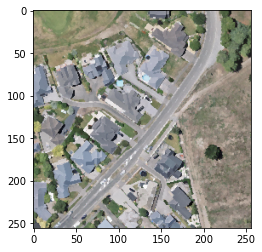

In [75]:
h, w, c = image2.size()
img = image2.permute(2,0,1).unsqueeze(dim=0)
print('img = ', img.shape)

res = s.forward(img)
if res.size(1) == 3:
    img_res = np.transpose(np.squeeze(res.data.numpy()), (1, 2, 0))
else:
    img_res = np.squeeze(res.data.numpy())
print(img_res.shape)
plt.imshow(img_res/255) # 显示图片

(3, 256, 256)


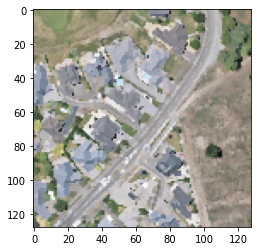

In [76]:
img=np.transpose(img_res,(2,0,1))
print(img.shape)
img = torch.FloatTensor(np.asarray(img)) 
image2=torch.nn.MaxPool2d(2)(img)
image2 = image2.permute(1,2,0)
plt.imshow(image2/255) # 显示图片

img =  torch.Size([1, 3, 128, 128])
L: tensor([[[[0.1667, 0.1667, 0.0000],
          [0.1667, 0.1667, 0.0000],
          [0.1667, 0.1667, 0.0000]]]])
R: tensor([[[[0.0000, 0.1667, 0.1667],
          [0.0000, 0.1667, 0.1667],
          [0.0000, 0.1667, 0.1667]]]])
U: tensor([[[[0.1667, 0.1667, 0.1667],
          [0.1667, 0.1667, 0.1667],
          [0.0000, 0.0000, 0.0000]]]])
D: tensor([[[[0.0000, 0.0000, 0.0000],
          [0.1667, 0.1667, 0.1667],
          [0.1667, 0.1667, 0.1667]]]])
NW: tensor([[[[0.2500, 0.2500, 0.0000],
          [0.2500, 0.2500, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])
NE: tensor([[[[0.0000, 0.2500, 0.2500],
          [0.0000, 0.2500, 0.2500],
          [0.0000, 0.0000, 0.0000]]]])
SW: tensor([[[[0.0000, 0.0000, 0.0000],
          [0.2500, 0.2500, 0.0000],
          [0.2500, 0.2500, 0.0000]]]])
SE: tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.2500, 0.2500],
          [0.0000, 0.2500, 0.2500]]]])
(128, 128, 3)


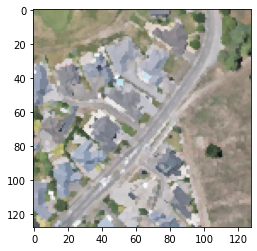

In [77]:
h, w, c = image2.size()
img = image2.permute(2,0,1).unsqueeze(dim=0)
print('img = ', img.shape)

res = s.forward(img)
if res.size(1) == 3:
    img_res = np.transpose(np.squeeze(res.data.numpy()), (1, 2, 0))
else:
    img_res = np.squeeze(res.data.numpy())
print(img_res.shape)
plt.imshow(img_res/255) # 显示图片

(3, 128, 128)


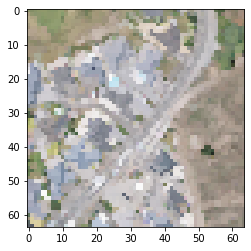

In [78]:
img=np.transpose(img_res,(2,0,1))
print(img.shape)
img = torch.FloatTensor(np.asarray(img)) 
image2=torch.nn.MaxPool2d(2)(img)
image2 = image2.permute(1,2,0)
plt.imshow(image2/255) # 显示图片

img =  torch.Size([1, 3, 64, 64])
L: tensor([[[[0.1667, 0.1667, 0.0000],
          [0.1667, 0.1667, 0.0000],
          [0.1667, 0.1667, 0.0000]]]])
R: tensor([[[[0.0000, 0.1667, 0.1667],
          [0.0000, 0.1667, 0.1667],
          [0.0000, 0.1667, 0.1667]]]])
U: tensor([[[[0.1667, 0.1667, 0.1667],
          [0.1667, 0.1667, 0.1667],
          [0.0000, 0.0000, 0.0000]]]])
D: tensor([[[[0.0000, 0.0000, 0.0000],
          [0.1667, 0.1667, 0.1667],
          [0.1667, 0.1667, 0.1667]]]])
NW: tensor([[[[0.2500, 0.2500, 0.0000],
          [0.2500, 0.2500, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])
NE: tensor([[[[0.0000, 0.2500, 0.2500],
          [0.0000, 0.2500, 0.2500],
          [0.0000, 0.0000, 0.0000]]]])
SW: tensor([[[[0.0000, 0.0000, 0.0000],
          [0.2500, 0.2500, 0.0000],
          [0.2500, 0.2500, 0.0000]]]])
SE: tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.2500, 0.2500],
          [0.0000, 0.2500, 0.2500]]]])
(64, 64, 3)


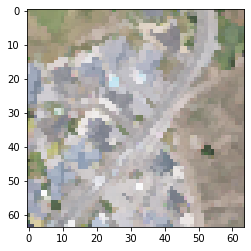

In [79]:
h, w, c = image2.size()
img = image2.permute(2,0,1).unsqueeze(dim=0)
print('img = ', img.shape)

res = s.forward(img)
if res.size(1) == 3:
    img_res = np.transpose(np.squeeze(res.data.numpy()), (1, 2, 0))
else:
    img_res = np.squeeze(res.data.numpy())
print(img_res.shape)
plt.imshow(img_res/255) # 显示图片

(3, 64, 64)


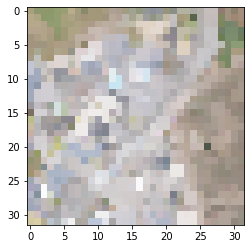

In [80]:
img=np.transpose(img_res,(2,0,1))
print(img.shape)
img = torch.FloatTensor(np.asarray(img)) 
image2=torch.nn.MaxPool2d(2)(img)
image2 = image2.permute(1,2,0)
plt.imshow(image2/255) # 显示图片

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SideWindowFilter(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 dilation=1, groups=1, bias=False):
        super(SideWindowFilter, self).__init__()
        print(kernel_size)
        print(kernel_size >= 3 )
        print(kernel_size % 2 == 1)
        assert kernel_size >= 3 and kernel_size % 2 == 1, 'kernel size must be great than 3 and odd'
        self.radius = kernel_size // 2
        # Original conv to get 3x3 filter parameters
        self.conv_ori = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, bias=bias, padding=self.radius,
                                  stride=stride, dilation=dilation, groups=groups)
        # 8 different directions side window convs
        self.conv_l = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, self.radius + 1), bias=bias,
                                padding=0, stride=stride, dilation=dilation, groups=groups)
        self.conv_r = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, self.radius + 1), bias=bias,
                                padding=0, stride=stride, dilation=dilation, groups=groups)
        self.conv_u = nn.Conv2d(in_channels, out_channels, kernel_size=(self.radius + 1, kernel_size), bias=bias,
                                padding=0, stride=stride, dilation=dilation, groups=groups)
        self.conv_d = nn.Conv2d(in_channels, out_channels, kernel_size=(self.radius + 1, kernel_size), bias=bias,
                                padding=0, stride=stride, dilation=dilation, groups=groups)
        self.conv_nw = nn.Conv2d(in_channels, out_channels, kernel_size=(self.radius + 1, self.radius + 1), bias=bias,
                                 padding=0, stride=stride, dilation=dilation, groups=groups)
        self.conv_ne = nn.Conv2d(in_channels, out_channels, kernel_size=(self.radius + 1, self.radius + 1), bias=bias,
                                 padding=0, stride=stride, dilation=dilation, groups=groups)
        self.conv_sw = nn.Conv2d(in_channels, out_channels, kernel_size=(self.radius + 1, self.radius + 1), bias=bias,
                                 padding=0, stride=stride, dilation=dilation, groups=groups)
        self.conv_se = nn.Conv2d(in_channels, out_channels, kernel_size=(self.radius + 1, self.radius + 1), bias=bias,
                                 padding=0, stride=stride, dilation=dilation, groups=groups)

    def set_filter(self, filter=None):
        if filter is not None:
            self.conv_ori.weight.data = filter
        self.conv_l.weight.data = self.conv_ori.weight.data[:, :, :, :self.radius + 1]
        self.conv_r.weight.data = self.conv_ori.weight.data[:, :, :, self.radius:]
        self.conv_u.weight.data = self.conv_ori.weight.data[:, :, :self.radius + 1, :]
        self.conv_d.weight.data = self.conv_ori.weight.data[:, :, self.radius:, :]
        self.conv_nw.weight.data = self.conv_ori.weight.data[:, :, :self.radius + 1, :self.radius + 1]
        self.conv_ne.weight.data = self.conv_ori.weight.data[:, :, :self.radius + 1, self.radius:]
        self.conv_sw.weight.data = self.conv_ori.weight.data[:, :, self.radius:, :self.radius + 1]
        self.conv_se.weight.data = self.conv_ori.weight.data[:, :, self.radius:, self.radius:]

    def forward(self, x):
        # F.pad(,[lllll, rrrrr, ttttt, bbbbb])
        x_l = F.pad(x, [self.radius, 0, self.radius, self.radius])
        x_r = F.pad(x, [0, self.radius, self.radius, self.radius])
        x_u = F.pad(x, [self.radius, self.radius, self.radius, 0])
        x_d = F.pad(x, [self.radius, self.radius, 0, self.radius])
        x_nw = F.pad(x, [self.radius, 0, self.radius, 0])
        x_ne = F.pad(x, [self.radius, 0, 0, self.radius])
        x_sw = F.pad(x, [0, self.radius, self.radius, 0])
        x_se = F.pad(x, [0, self.radius, 0, self.radius])

        # 8 directions side window conv
        x_l = self.conv_l(x_l)
        x_r = self.conv_r(x_r)
        x_u = self.conv_u(x_u)
        x_d = self.conv_d(x_d)
        x_nw = self.conv_nw(x_nw)
        x_ne = self.conv_ne(x_ne)
        x_sw = self.conv_sw(x_sw)
        x_se = self.conv_se(x_se)

        # Normalized output
        x_l = x_l * torch.sum(self.conv_ori.weight.data) / torch.sum(self.conv_l.weight.data) - x
        x_r = x_r * torch.sum(self.conv_ori.weight.data) / torch.sum(self.conv_r.weight.data) - x
        x_u = x_u * torch.sum(self.conv_ori.weight.data) / torch.sum(self.conv_u.weight.data) - x
        x_d = x_d * torch.sum(self.conv_ori.weight.data) / torch.sum(self.conv_d.weight.data) - x
        x_nw = x_nw * torch.sum(self.conv_ori.weight.data) / torch.sum(self.conv_nw.weight.data) - x
        x_ne = x_ne * torch.sum(self.conv_ori.weight.data) / torch.sum(self.conv_ne.weight.data) - x
        x_sw = x_sw * torch.sum(self.conv_ori.weight.data) / torch.sum(self.conv_sw.weight.data) - x
        x_se = x_se * torch.sum(self.conv_ori.weight.data) / torch.sum(self.conv_se.weight.data) - x

        # Take the min
        x_stack = torch.stack((x_l, x_r, x_u, x_d, x_nw, x_ne, x_sw, x_se), dim=2)
        b, c, d, h, w = x_stack.shape
        x_stack_min_mask = torch.argmin(torch.abs(x_stack), dim=2, keepdim=True)
        x_stack = torch.gather(x_stack, dim=2, index=x_stack_min_mask)
        x_stack = x_stack.view(b, c, h, w)

        return x_stack + x


import numpy as np
from PIL import Image
from torch.autograd import Variable


def preprocess_image(pil_im):
    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
    im_as_ten = torch.from_numpy(im_as_arr).float()
    im_as_ten.unsqueeze_(0)
    im_as_var = Variable(im_as_ten, requires_grad=False)
    with torch.no_grad():
        im_as_var = torch.autograd.Variable(im_as_var)
    return im_as_var


def recover_image(im_as_var):
    im_as_var = im_as_var.squeeze_()
    img = im_as_var.detach().numpy()
    for channel, _ in enumerate(img):
        img[channel] *= 255
    img = img.transpose(1, 2, 0)
    img = Image.fromarray(np.uint8(img), 'RGB')
    return img


def sidewindowfilter(img, swf):
    b, c, w, h = img.shape
    for i in range(c):
        img[:, i, :, :] = swf(img[:, i, :, :].view(b, 1, w, h)).view(b, w, h)
    return img


def process(img_path, filter, iteration=1):
    img = Image.open(img_path).convert('RGB')
    # img.show()

    img_as_var = preprocess_image(img)
    if filter is not None:
        swf = SideWindowFilter(1, 1, filter.shape[-1])
        filter = torch.from_numpy(filter).float()
        swf.set_filter(filter)
    else:
        swf = SideWindowFilter(1, 1, 3)
    for _ in range(iteration):
        img_as_var = sidewindowfilter(img_as_var, swf)

    img = recover_image(img_as_var)
    # img.show()
    return img


In [44]:
img_path = r'G:\zyx\data\data_png\test\image\2_1.png'  # img path

filter = np.array([[[[0.0453542, 0.0566406, 0.0453542],
                     [0.0566406, 0.0707355, 0.0566406],
                     [0.0453542, 0.0566406, 0.0453542]]]], dtype=np.float)
filter /= np.sum(filter)  # Gauss filter
print(filter.shape)
# filter = np.array([[[[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]]], dtype=np.float)  # mean filter
img = process(img_path, filter=filter, iteration=1)
print(img.size)
img.save('img/process.jpg')

(1, 1, 3, 3)
3
True
True
(512, 512)


FileNotFoundError: [Errno 2] No such file or directory: 'img/process.jpg'